# [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

A Pytorch Implementation

In [1]:
! pip install torchscan

In [2]:
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [3]:
# To be used as the feature extractor, in order to compare the features

class FeatExt(nn.Module):
    def __init__(self):
        super(FeatExt, self).__init__()

        # input.shape: (1, 105, 105)

        self.cnn1 = nn.Conv2d(1, 64, kernel_size=10) # (1, 105, 105) -> (64, 96, 96)
        self.relu1 = nn.ReLU()

        # feature maps.shape: (64, 96, 96)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2) # (64, 96, 96) -> (64, 48, 48)

        # feature maps.shape: (64, 48, 48)
        self.cnn2 = nn.Conv2d(64, 128, kernel_size=7) # (64, 48, 48) -> (128, 42, 42)
        self.relu2 = nn.ReLU()

        # feature maps.shape: (128, 42, 42)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2) # (128, 42, 42) -> (128, 21, 21)

        # feature maps.shape: (128, 21, 21)
        self.cnn3 = nn.Conv2d(128, 128, kernel_size=4) # (128, 21, 21) -> (128, 18, 18)
        self.relu3 = nn.ReLU()

        # feature maps.shape: (128, 18, 18)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2) # (128, 18, 18) -> (128, 9, 9)

        # feature maps.shape: (128, 9, 9)
        self.cnn4 = nn.Conv2d(128, 256, kernel_size=4) # (128, 9, 9) -> (256, 6, 6)
        self.relu4 = nn.ReLU()

        # feature maps.shape: (256, 6, 6)
        # torch.flatten: (256, 6, 6) -> (9216)

        # feature maps.shape: (9216)
        self.fc1 = nn.Linear(9216, 4096) # (9216) -> (4096)
        self.sigmoid1 = nn.Sigmoid()

        # # feature maps.shape: (4096)
        # self.fc2 = nn.Linear(4096, 1)
        # self.sigmoid2 = nn.Sigmoid()


    def forward(self, x):
        x = self.max_pool1(self.relu1(self.cnn1(x)))

        x = self.max_pool2(self.relu2(self.cnn2(x)))

        x = self.max_pool3(self.relu3(self.cnn3(x)))

        x = self.relu4(self.cnn4(x))

        x = torch.flatten(x, start_dim=1)

        x = self.sigmoid1(self.fc1(x))

        # x = self.sigmoid2(self.fc2(x))

        return x


# if __name__ == '__main__':
#     model = SiameseNet()
#     batch_size = 5
#     input = torch.rand(size=(batch_size, 1, 105, 105))
#     out = model(input)
#     print(input.shape, out.shape)
#     assert tuple(out.shape) == (batch_size, 1)

In [4]:
class SiameseNet(nn.Module):
  def __init__(self):
    super(SiameseNet, self).__init__()
    self.feat = FeatExt()
    
    # feature maps.shape: (4096)
    self.fc = nn.Linear(4096, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x1, x2):
    x1 = self.feat(x1)
    x2 = self.feat(x2)

    return self.sigmoid(self.fc((x1-x2).abs()))

#### Weight Initilization

* They initialized all network weights
in the convolutional layers from a normal distribution with
zero-mean and a standard deviation of `10−2`
* Biases were
also initialized from a normal distribution, but with mean `0.5` and standard deviation `10−2`
* In the fully-connected
layers, the biases were initialized in the same way as the
convolutional layers, but the weights were drawn from a
much wider normal distribution with zero-mean and standard deviation `2 × 10−1`
.

In [48]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, 0, 2e-1)
    nn.init.normal_(m.bias, 0, 1e-2)
  elif type(m) == nn.Conv2d:
    nn.init.normal_(m.weight, 0, 1e-2)
    nn.init.normal_(m.bias, 0.5, 1e-2)


In [5]:
# Just a quick check that every thing works as it should be

model = SiameseNet()
batch_size = 5
input = torch.rand(size=(batch_size, 1, 105, 105))
out = model(input, input)
print(input.shape, out.shape)
assert tuple(out.shape) == (batch_size, 1)

torch.Size([5, 1, 105, 105]) torch.Size([5, 1])


## Getting & preparing the dataset

In [6]:
import os

working_dir = '/content/drive/MyDrive/siamese_net'
os.chdir(working_dir)

In [7]:
from torchvision.datasets import Omniglot
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [8]:
ds = Omniglot(root='./data', download=True, transform=np.array, background=True)

Files already downloaded and verified


Note: For our training, we are creating dataset in such a way, that 1 means both images are similar, while 0 means they are dis-similar

In [98]:
# https://github.com/Rhcsky/siamese-one-shot-pytorch/blob/main/data_loader.py

from collections import defaultdict

class OmniglotDS(Dataset):
  def __init__(self, ds):
    super(OmniglotDS, self).__init__()
    self.ds = ds
    self.mean = 0.8444
    self.std = 0.5329
    self.imgs = defaultdict(list)
    
    self.data = [ds[i] for i in range(1200)]
    # self.data = ds
    for img, label in tqdm(self.data, desc='Iterating over omniglot'):
      self.imgs[label].append(img)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img1, cls1 = random.choice(self.data) 

    # if they are from same class
    if idx % 2 == 1:
      label = 1.0
      img2, cls2 = random.choice(self.imgs[cls1]), cls1 
    # they are from different class
    else:
      label = 0.0
      options = list(set(self.imgs.keys()) - {cls1})
      
      cls2 = random.choice(options)
      img2 = random.choice(self.imgs[cls2]) 
    img1, img2 = np.array(img1, dtype=np.float32) / 255, np.array(img2, dtype=np.float32) / 255
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0) 

    return {
        'img1': torch.from_numpy(img1),
        'img2': torch.from_numpy(img2),
        'label': torch.from_numpy(np.array([label], dtype=np.float32))
    }



In [99]:
dl = DataLoader(OmniglotDS(ds), batch_size=128)

In [100]:
len(dl), len(dl.dataset)

(10, 1200)

In [101]:
for x in OmniglotDS(ds):
  print(x['img1'].shape, x['img2'].shape)
  break


torch.Size([1, 105, 105]) torch.Size([1, 105, 105])


## Loss & optimizers

- Binary Cross Entropy Loss with L2 Norm

In [46]:
from torch.optim import Adam
from torchsummary import summary


In [117]:
model.apply(init_weights)

SiameseNet(
  (feat): FeatExt(
    (cnn1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (relu1): ReLU()
    (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (cnn2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (relu2): ReLU()
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (cnn3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (relu3): ReLU()
    (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (cnn4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (relu4): ReLU()
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (sigmoid1): Sigmoid()
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterian = nn.BCELoss()
optimizer = Adam(model.parameters(), weight_decay=0.1)
model = model.to(device)

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [103]:
summary(model, [(1, 105, 105), (1, 105, 105)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           6,464
              ReLU-2           [-1, 64, 96, 96]               0
         MaxPool2d-3           [-1, 64, 48, 48]               0
            Conv2d-4          [-1, 128, 42, 42]         401,536
              ReLU-5          [-1, 128, 42, 42]               0
         MaxPool2d-6          [-1, 128, 21, 21]               0
            Conv2d-7          [-1, 128, 18, 18]         262,272
              ReLU-8          [-1, 128, 18, 18]               0
         MaxPool2d-9            [-1, 128, 9, 9]               0
           Conv2d-10            [-1, 256, 6, 6]         524,544
             ReLU-11            [-1, 256, 6, 6]               0
           Linear-12                 [-1, 4096]      37,752,832
          Sigmoid-13                 [-1, 4096]               0
          FeatExt-14                 [-

## Training Loop 

- LR Schedular

To Do:   
(In Learning Rate Schedule Section): We fixed momentum to start at 0.5 in every layer,
increasing linearly each epoch until reaching the value µj ,
the individual momentum term for the jth layer.

In [104]:
NUM_EPOCH, print_every = 301, 50

In [119]:
losses = []

for epoch in tqdm(range(NUM_EPOCH), desc='Training...'):
  running_loss = 0.0
  for batch in dl:
    img1, img2, label = batch['img1'].to(device), batch['img2'].to(device), batch['label'].to(device)
    optimizer.zero_grad()

    out = model(img1, img2)
    loss = criterian(out, label)

    running_loss += loss.item() * out.shape[0]

    loss.backward()
    optimizer.step()

  scheduler.step()
  running_loss = running_loss / len(dl.dataset)
  losses.append(running_loss)
  if epoch % print_every == 0:
    print(f'Epoch: {epoch}, Loss: {running_loss:.2f}')


Epoch: 0, Loss: 0.69
Epoch: 50, Loss: 0.45
Epoch: 100, Loss: 0.50
Epoch: 150, Loss: 0.49
Epoch: 200, Loss: 0.48
Epoch: 250, Loss: 0.51
Epoch: 300, Loss: 0.50



Text(0, 0.5, 'Loss')

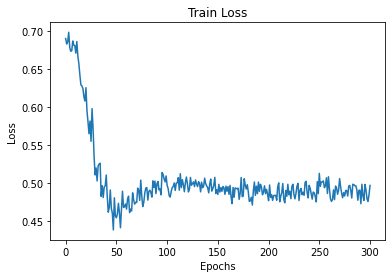

In [120]:
 plt.plot(losses)
 plt.title('Train Loss')
 plt.xlabel('Epochs')
 plt.ylabel('Loss')

In [121]:
torch.save({
    'state_dict': model.state_dict()
 }, './weights/dict.pth')

In [122]:
! pwd && ls weights

/content/drive/My Drive/siamese_net
dict.pth


## Visualizations

In [123]:
from PIL import Image
from matplotlib import pyplot as plot
from collections import defaultdict

In [124]:
images = defaultdict(list)

In [125]:
for img, label in ds:
  images[label].append(img)
  
  if len(images) > 4:
    break

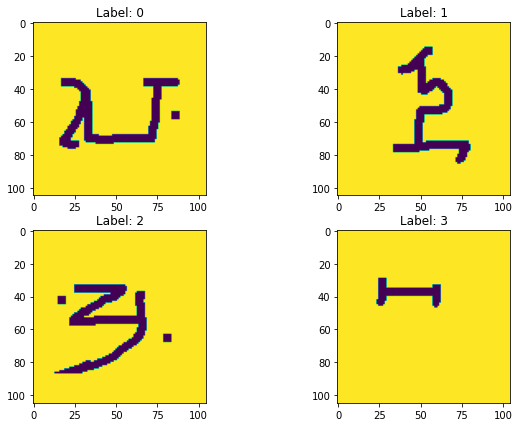

In [126]:
# display all images of diff class

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

for i in range(4):
  img = images[i][0]
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.title(f'Label: {i}')

plt.show()

In [127]:
assert len(images[0]) >= 4

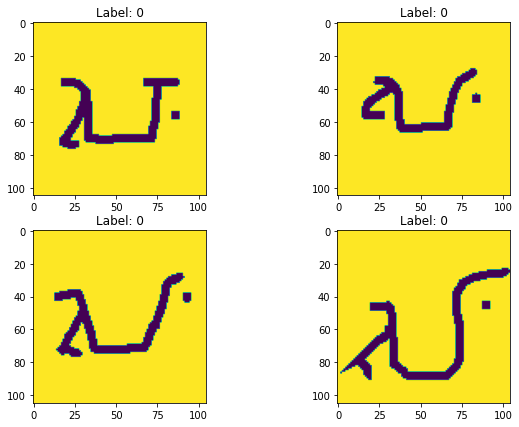

In [128]:
# display all images of same class

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2

for i in range(4):
  img = images[0][i]
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.title(f'Label: 0')

plt.show()

Note that, for our training, output of 1 means, both images are similar, and 0 means both are different (see the dataset we created)

In [129]:
model = model.cpu()
x, y = np.array([images[0][0]], dtype=np.float32), np.array([images[0][1]], dtype=np.float32)
x, y = torch.from_numpy(np.expand_dims(x, axis=0)), torch.from_numpy(np.expand_dims(y, axis=0))
z = np.array([images[2][1]], dtype=np.float32)
z = torch.from_numpy(np.expand_dims(z, axis=0))
print(f'Scores for same class (0) is: {model(x, y).item(): .3f}, and for different classes (0, 2) is: {model(x, z).item(): .3f}')

Scores for same class (0) is:  0.989, and for different classes (0, 2) is:  0.898


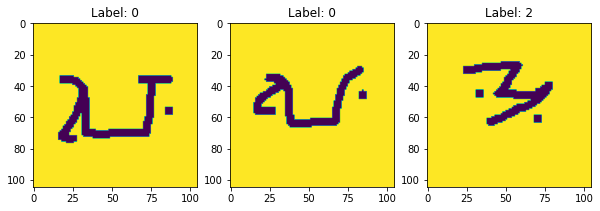

In [130]:
# display all images of same class

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.imshow(images[0][0])
plt.title(f'Label: 0')

fig.add_subplot(rows, columns, 2)
plt.imshow(images[0][1])
plt.title(f'Label: 0')

fig.add_subplot(rows, columns, 3)
plt.imshow(images[2][1])
plt.title(f'Label: 2')

plt.show()

## Rough

In [ ]:
l = nn.BCELoss()

x, y = torch.tensor([[0.01]]), torch.tensor([[1.0]])
print(x, y, l(x, y))

tensor([[0.0100]]) tensor([[1.]]) tensor(4.6052)


In [35]:
from PIL import Image
from matplotlib import pyplot as plot
from collections import defaultdict

In [36]:
images = defaultdict(list)

In [37]:
for img, label in ds:
  images[label].append(img)
  
  if len(images) > 4:
    break

In [38]:
images.keys()

dict_keys([0, 1, 2, 3, 4])

In [17]:
Image.fromarray(x[0]).show()

In [18]:
x[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)